In [1]:
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as ipd
from scipy.io.wavfile import read
import scipy.signal as signal
from scipy.fftpack import fft, ifft

In [2]:
def read_sound(file):
  """ read a mono wav sound file, assuming is mono, and convert it to a floating point array
    Args:
      file (str): File name
    Returns:
      sound_array (numpy.array): Array of samples as floating point values between -1 and 1
      sampling_rate (int): Sampling rate
  """
  # read sound file
  sampling_rate, x = read(file)
  # convert to floating point values between -1 and 1, assuming x are 16 bit integers
  sound_array = np.float32(x) / 2**15
  return sound_array, sampling_rate

def display_sound(sound_array, sampling_rate=44100):
  """ Display signal sound_array
    Args:
      sound_array (numpy.array): Array of samples
      sampling_rate (int): Sampling rate
  """
  # plot the waveform of the sound
  plt.figure(0, figsize=(10, 4))
  time_indexes = np.arange(0, sound_array.size/sampling_rate, 1.0/sampling_rate)
  plt.plot(time_indexes, sound_array)
  plt.xlabel('time (seconds)')
  plt.ylabel('amplitude')
  plt.show()
  # play the sound
  ipd.display(ipd.Audio(data=sound_array, rate=sampling_rate))

# Define the Bark scale conversion function
def hz2bark(f):
    """ Usage: Bark=hz2bark(f)
    f    : (ndarray)    Array containing frequencies in Hz.
    Returns  :
    Brk  : (ndarray)    Array containing Bark scaled values.
    """
    Brk = 6. * np.arcsinh(f/600.)
    return Brk

def bark2hz(Brk):
    """ Usage:
    Hz=bark2hs(Brk)
    Args     :
        Brk  : (ndarray)    Array containing Bark scaled values.
    Returns  :
        Fhz  : (ndarray)    Array containing frequencies in Hz.
    """

    Fhz = 600. * np.sinh(Brk/6.)
    return Fhz

def f_SP_dB(maxfreq,nfilts):
    #usage: spreadingfunctionmatdB=f_SP_dB(maxfreq,nfilts)
    #computes the spreading function protoype, in the Bark scale.
    #Arguments: maxfreq: half the sampling freqency
    #nfilts: Number of subbands in the Bark domain, for instance 64

    maxbark=hz2bark(maxfreq) #upper end of our Bark scale:22 Bark at 16 kHz

    #Number of our Bark scale bands over this range: nfilts=64
    spreadingfunctionBarkdB=np.zeros(2*nfilts)

    #Spreading function prototype, "nfilts" bands for lower slope
    spreadingfunctionBarkdB[0:nfilts]=np.linspace(-maxbark*27,-8,nfilts)-23.5

    #"nfilts" bands for upper slope:
    spreadingfunctionBarkdB[nfilts:2*nfilts]=np.linspace(0,-maxbark*12.0,nfilts)-23.5
    return spreadingfunctionBarkdB

def mapping2bark(mX,W,nfft):
    #Maps (warps) magnitude spectrum vector mX from DFT to the Bark scale
    #arguments: mX: magnitude spectrum from fft
    #W: mapping matrix from function mapping2barkmat
    #nfft: : number of subbands in fft
    #returns: mXbark, magnitude mapped to the Bark scale

    nfreqs= nfft//2

    #Here is the actual mapping, suming up powers and conv. back to Voltages:
    mXbark = (np.dot( np.abs(mX[:nfreqs])**2.0, W[:, :nfreqs].T))**(0.5)

    return mXbark

def mappingfrombark(mTbark,W_inv,nfft):
    #usage: mT=mappingfrombark(mTbark,W_inv,nfft)
    #Maps (warps) magnitude spectrum vector mTbark in the Bark scale
    # back to the linear scale
    #arguments:
    #mTbark: masking threshold in the Bark domain
    #W_inv : inverse mapping matrix W_inv from matrix W for mapping back from bark scale
    #nfft: : number of subbands in fft
    #returns: mT, masking threshold in the linear scale

    nfreqs = nfft//2
    mT = np.dot(mTbark, W_inv[:, :nfreqs].T)
    return mT

def maskingThresholdBark(mXbark,spreadingfuncmatrix,alpha,fs,nfilts):
    #Computes the masking threshold on the Bark scale with non-linear superposition
    #usage: mTbark=maskingThresholdBark(mXbark,spreadingfuncmatrix,alpha)
    #Arg: mXbark: magnitude of FFT spectrum, on the Bark scale
    #spreadingfuncmatrix: spreading function matrix from function spreadingfunctionmat
    #alpha: exponent for non-linear superposition (eg. 0.6),
    #fs: sampling freq., nfilts: number of Bark subbands
    #nfilts: Number of subbands in the Bark domain, for instance 64
    #Returns: mTbark: the resulting Masking Threshold on the Bark scale

    #Compute the non-linear superposition:
    mTbark = np.dot(mXbark**alpha, spreadingfuncmatrix**alpha)

    #apply the inverse exponent to the result:
    mTbark = mTbark**(1.0/alpha)

    #Threshold in quiet:
    maxfreq = fs/2.0
    maxbark = hz2bark(maxfreq)
    step_bark = maxbark/(nfilts-1)
    barks=np.arange(0,nfilts)*step_bark

    #convert the bark subband frequencies to Hz:
    f=bark2hz(barks)+1e-6
    #Threshold of quiet in the Bark subbands in dB:
    LTQ=np.clip((3.64*(f/1000.)**-0.8 -6.5*np.exp(-0.6*(f/1000.-3.3)**2.)+1e-3*((f/1000.)**4.)),-20,160)
    #Maximum of spreading functions and hearing threshold in quiet:
    mTbark=np.max((mTbark, 10.0**((LTQ-60)/20)),0)
    return mTbark

def mapping2barkmat(fs, nfilts, nfft):
  #Constructing matrix W which has 1’s for each Bark subband, and 0’s else:
  #nfft=2048; nfilts=64;
  nfreqs=nfft//2
  step_barks = maxbark/(nfilts-1)
  #the linspace produces an array with the fft band edges:
  binbarks = hz2bark(np.linspace(0,(nfft//2),(nfft//2)+1)*fs/nfft)
  W = np.zeros((nfilts, nfft))
  for i in range(nfilts):
    W[i,0:(nfft//2)+1] = (np.round(binbarks/step_barks)== i)
  return W

def mappingfrombarkmat(W,nfft):
    #Constructing inverse mapping matrix W_inv from matrix W for mapping back from bark scale
    #usuage: W_inv=mappingfrombarkmat(Wnfft)
    #argument: W: mapping matrix from function mapping2barkmat
    #nfft: : number of subbands in fft
    nfreqs=int(nfft/2)
    W_inv= np.dot(np.diag((1.0/np.sum(W,1))**0.5), W[:,0:nfreqs + 1]).T
    return W_inv

def spreadingfunctionmat(spreadingfunctionBarkdB,alpha,nfilts):
    #Turns the spreading prototype function into a matrix of shifted versions.
    #Convert from dB to "voltage" and include alpha exponent
    #nfilts: Number of subbands in the Bark domain, for instance 64
    spreadingfunctionBarkVoltage=10.0**(spreadingfunctionBarkdB/20.0*alpha)

    #Spreading functions for all bark scale bands in a matrix:
    spreadingfuncmatrix=np.zeros((nfilts,nfilts))

    for k in range(nfilts):
        spreadingfuncmatrix[k,:]=spreadingfunctionBarkVoltage[(nfilts-k):(2*nfilts-k)]

    return spreadingfuncmatrix

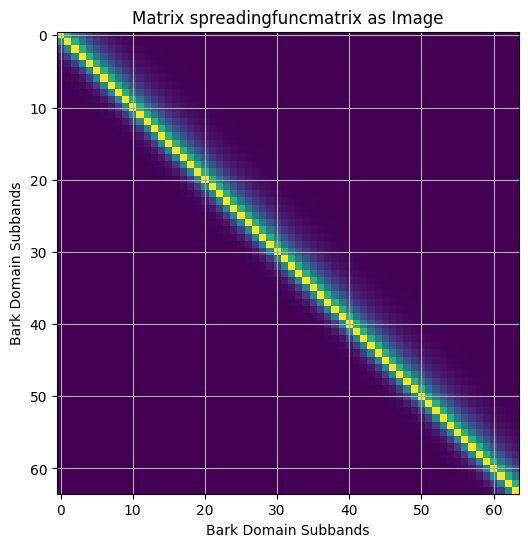

In [3]:
fs = 44100
maxfreq = fs/2
alpha = 0.8
nfilts = 64
N = 2048

spreadingfunctionBarkdB = f_SP_dB(maxfreq,nfilts)
spreadingfuncmatrix = spreadingfunctionmat(spreadingfunctionBarkdB, alpha, nfilts)

plt.figure(figsize=(10,6))
plt.imshow(spreadingfuncmatrix)
plt.title('Matrix spreadingfuncmatrix as Image')
plt.xlabel('Bark Domain Subbands')
plt.ylabel('Bark Domain Subbands')
plt.grid()

maxfreq= 22050.0 maxbark= 25.784822777395576


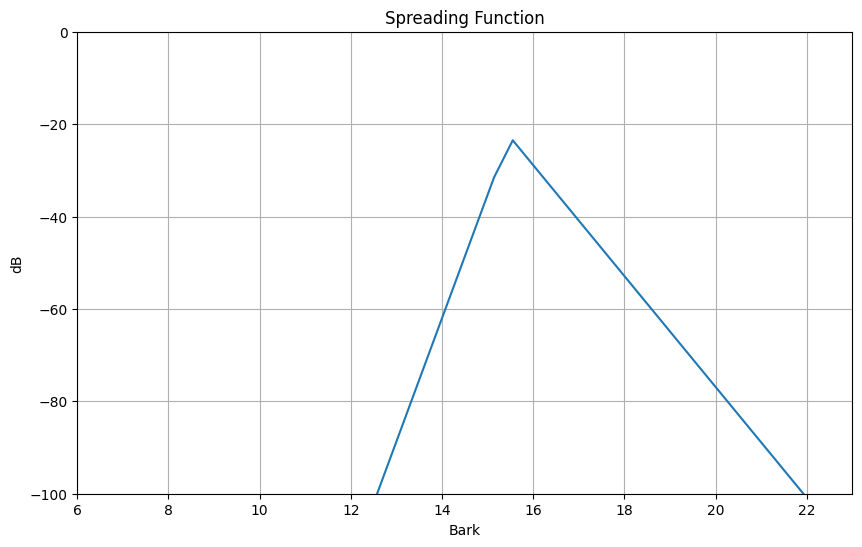

In [4]:
# generate and plot a masking curve

#x-axis: maxbark Bark in nfilts steps:
maxbark=hz2bark(maxfreq)
print("maxfreq=", maxfreq, "maxbark=", maxbark)

bark=np.linspace(0, maxbark, nfilts)

#The prototype over "nfilt" bands or 22 Bark, its center
#shifted down to 22-26/nfilts*22=13 Bark:
plt.figure(figsize=(10,6))
plt.plot(bark,spreadingfunctionBarkdB[26:(26+nfilts)])
plt.axis([6,23,-100,0])
plt.xlabel('Bark')
plt.ylabel('dB')
plt.title('Spreading Function')
plt.grid()

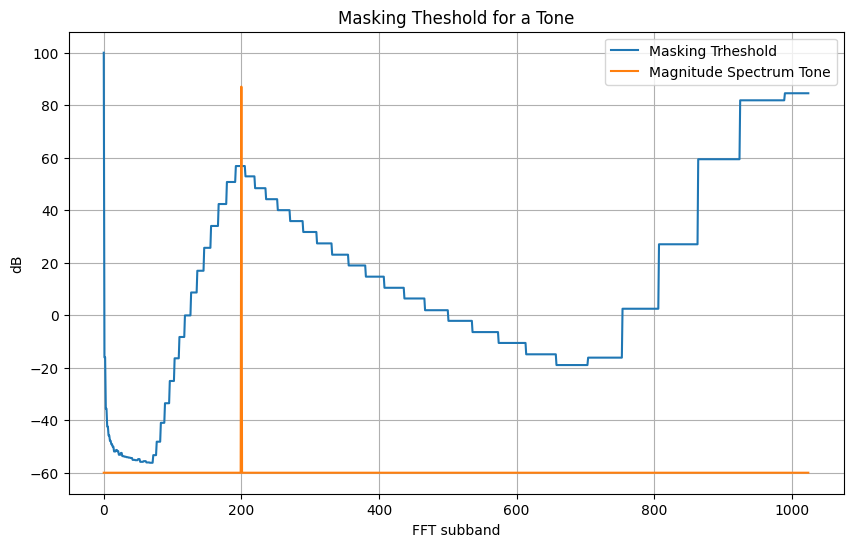

In [5]:
#A test magnitude spectrum, an idealized tone in one subband:
#tone at FFT band 200:
x=np.sin(2*np.pi/N*200*np.arange(32000))*1000
ipd.Audio(x,rate=32000)

W = mapping2barkmat(fs, nfilts, N)
W_inv = mappingfrombarkmat(W, N)
spreadingfuncmatrix=spreadingfunctionmat(spreadingfunctionBarkdB, alpha, nfilts)

mX=np.abs(np.fft.fft(x[0:2048],norm='ortho'))[0:1025]

#Compute the masking threshold in the Bark domain:
mXbark=mapping2bark(mX,W,N)
mTbark=maskingThresholdBark(mXbark,spreadingfuncmatrix,alpha,fs,nfilts)
mT=mappingfrombark(mTbark,W_inv,N)
plt.figure(figsize=(10,6))
plt.plot(20*np.log10(mT+1e-3))
plt.title('Masking Theshold for a Tone'),
plt.plot(20*np.log10(mX+1e-3))
plt.legend(('Masking Trheshold', 'Magnitude Spectrum Tone'))
plt.xlabel('FFT subband')
plt.ylabel("dB")
plt.grid()

1025 64 1025


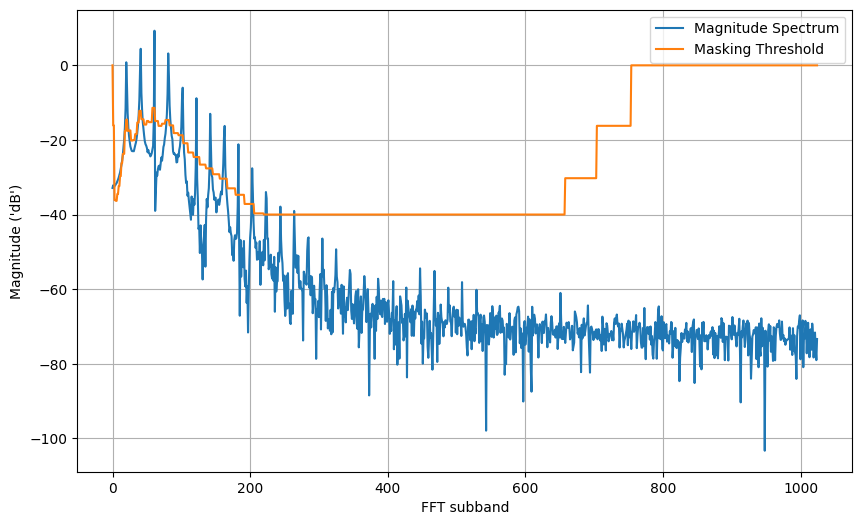

In [6]:
#
# x, fs = read_sound('../sounds/white-noise.wav')
x, fs = read_sound('../sounds/487465-trumpet.wav')

W = mapping2barkmat(fs, nfilts, N)
W_inv = mappingfrombarkmat(W, N)
spreadingfuncmatrix = spreadingfunctionmat(spreadingfunctionBarkdB, alpha, nfilts)


mX = np.abs(np.fft.fft(x[10000:10000+N],norm='ortho'))[0:N//2+1]
mXbark = mapping2bark(mX, W, N)
# Compute the masking threshold in the Bark domain:
mTbark =  maskingThresholdBark(mXbark, spreadingfuncmatrix, alpha, fs, nfilts)


# Masking threshold in the original frequency domain
mT = 20*np.log10(mappingfrombark(mTbark, W_inv, N))
mX = 20*np.log10(mX)
print(mX.size, mTbark.size, mT.size)
mT = np.clip(mT,-40,0)
plt.figure(figsize=(10,6))
plt.plot(mX)
plt.plot(mT)
plt.legend(('Magnitude Spectrum','Masking Threshold'))
plt.xlabel('FFT subband')
plt.ylabel("Magnitude ('dB')")
plt.grid()


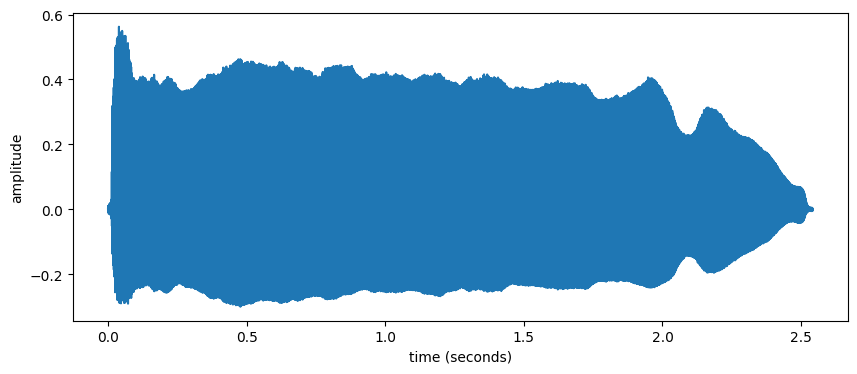

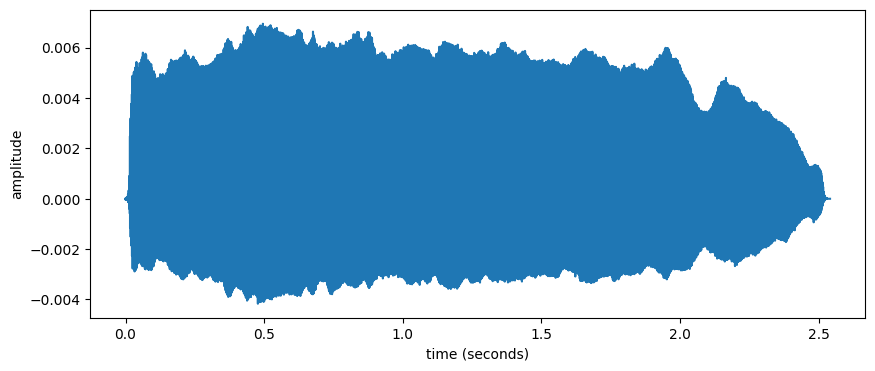

In [7]:
# compute the frequency masking curve for each frame of a sound and subtract it from the sound
y = np.zeros(len(x))
i = 0
while i < x.size-N:
  w = signal.get_window('hann', N)
  xw = x[i:i+N] * w
  X = fft(xw)
  mX = 20 * np.log10(abs(X))
  pX = np.angle(X)

  mXbark = mapping2bark(mX, W, N)
  # Compute the masking threshold in the Bark domain:
  mTbark =  maskingThresholdBark(mXbark, spreadingfuncmatrix, alpha, fs, nfilts)
  # Masking threshold in the original frequency domain
  mT = 20 * np.log10(mappingfrombark(mTbark, W_inv, N))
  masking_curve = np.append(mT, np.flip(mT[:N//2-1])) - 60
  masking_curve = np.clip(masking_curve,-50,0)
  mX += masking_curve
  Y = 10 ** (mX/20) * np.exp(1j * pX)
  yt = np.real(ifft(Y))
  y[i:i+N] += yt
  i += N//2

display_sound(x, fs)
display_sound(y, fs)